In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
from matplotlib.pyplot import figure
import seaborn as sns
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Denawaka_multivariate.csv',parse_dates=['Time'], index_col='Time')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,96.3,22.0,31.9,75.0,94.0,1633991
2013-02-01,228.3,22.5,33.5,72.0,94.0,1094607
2013-03-01,319.2,23.1,34.0,77.0,97.0,2145374
2013-04-01,280.6,24.1,34.3,76.0,97.0,4632494
2013-05-01,492.3,24.5,31.5,83.0,95.0,2567256


In [4]:
#Checking for missing values
df.isna().sum()

Rainfall     0
Temp_min     1
Temp_max     1
Hum_min      1
Hum_max     10
Power        0
dtype: int64

In [5]:
df=df.resample('MS').first()

In [6]:
#removing missing values
df=df.fillna(method='bfill')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,96.3,22.0,31.9,75.0,94.0,1633991
2013-02-01,228.3,22.5,33.5,72.0,94.0,1094607
2013-03-01,319.2,23.1,34.0,77.0,97.0,2145374
2013-04-01,280.6,24.1,34.3,76.0,97.0,4632494
2013-05-01,492.3,24.5,31.5,83.0,95.0,2567256


In [7]:
df=df[['Temp_min','Temp_max','Hum_min','Hum_max','Rainfall']]

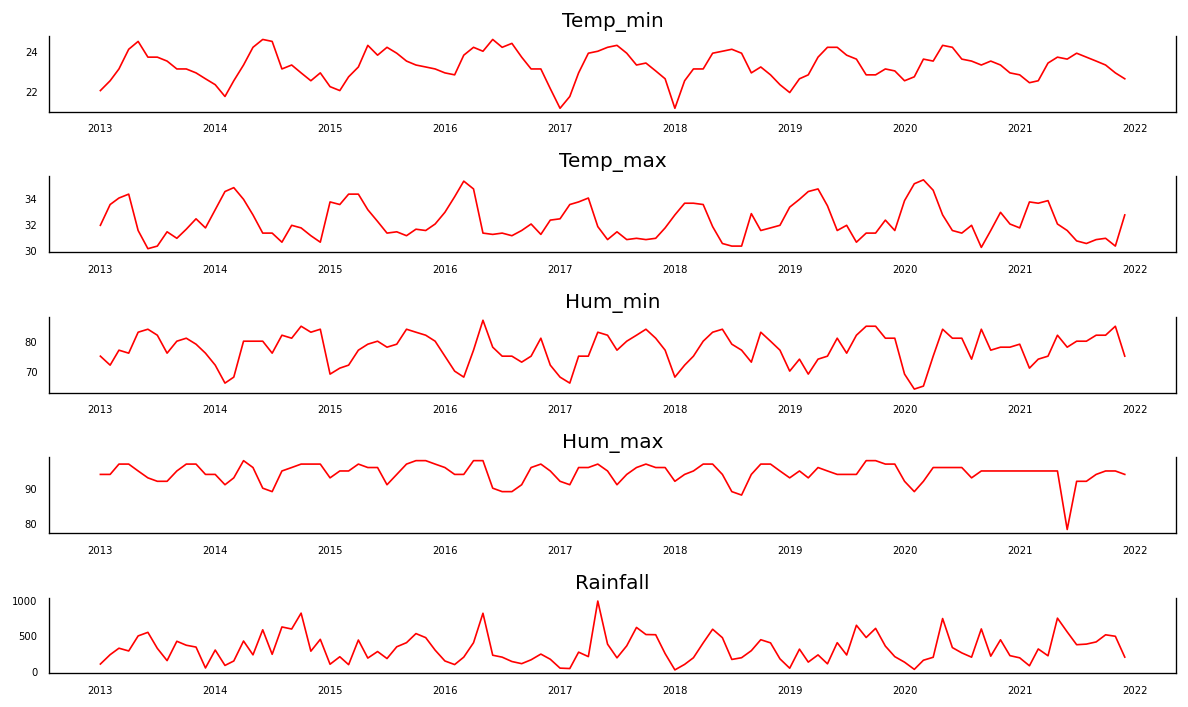

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

    H0: Series is not stationary
    H1: Series is Stationary

In [9]:
### ADF Test
col=df.columns
for i in range(len(col)):
    test_result=adfuller(df[col[i]])
    def adfuller_test(x):
        result=adfuller(x)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, "+col[i]+" series is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating " + col[i] + " series is non-stationary ")

    adfuller_test(df[col[i]])

ADF Test Statistic : -2.1280093887612805
p-value : 0.23340203111752356
#Lags Used : 12
Number of Observations Used : 95
weak evidence against null hypothesis, time series has a unit root, indicating Temp_min series is non-stationary 
ADF Test Statistic : -1.71084269823937
p-value : 0.42553482915755203
#Lags Used : 11
Number of Observations Used : 96
weak evidence against null hypothesis, time series has a unit root, indicating Temp_max series is non-stationary 
ADF Test Statistic : -3.267843333704172
p-value : 0.016378511546009108
#Lags Used : 10
Number of Observations Used : 97
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_min series is stationary
ADF Test Statistic : -7.579272246968897
p-value : 2.7090280606455283e-11
#Lags Used : 2
Number of Observations Used : 105
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_max series is stationary
ADF Test Statistic : -3.508061258091271
p-value : 0.00778246

#### According to the ADF test, only the Temp_min and Temp_max series are non-stationary. Therefore it needs to difference the series.

In [10]:
ad_fuller_result_1 = adfuller(df['Temp_min'].diff()[1:])

print('Temp_min')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

Temp_min
ADF Statistic: -5.4362520869722335
p-value: 2.841277057912391e-06


In [11]:
ad_fuller_result_2 = adfuller(df['Temp_max'].diff()[1:])

print('Temp_max')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Temp_max
ADF Statistic: -9.687516655860511
p-value: 1.1598777095571225e-16


In [12]:
#Combine first differenced Temp_min with rest.
df['Temp_min']=df['Temp_min'].diff()[1:]
df['Temp_max']=df['Temp_max'].diff()[1:]
#df= df.iloc[1: , :] #Remioving the first column
#Checking for missing values
df.isna().sum()

Temp_min    1
Temp_max    1
Hum_min     0
Hum_max     0
Rainfall    0
dtype: int64

In [13]:
#removing missing values
df=df.dropna(how="any")
df.head()

,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,
2013-02-01,0.5,1.6,72.0,94.0,228.3
2013-03-01,0.6,0.5,77.0,97.0,319.2
2013-04-01,1.0,0.3,76.0,97.0,280.6
2013-05-01,0.4,-2.8,83.0,95.0,492.3
2013-06-01,-0.8,-1.4,84.0,93.0,542.8


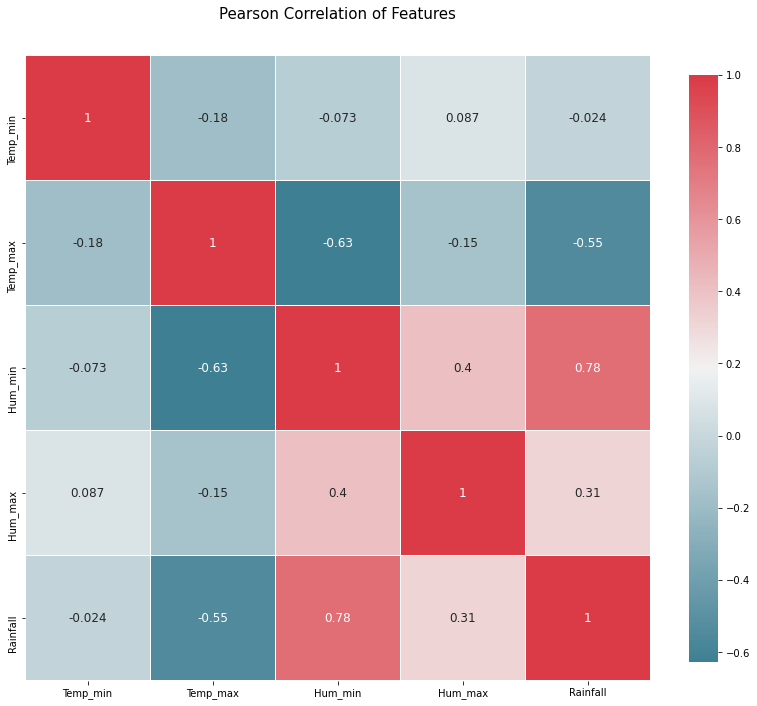

In [14]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Fitting ARIMAX model

### Feature Engineering

In [32]:
def feature_engineering(data):
    data['Time'] = pd.to_datetime(data['Time'])
    data["Time"] = pd.to_datetime(data["Time"], format="%Y-%m-%d")
    data["year"] = data["Time"].dt.year
    data["month"] = data["Time"].dt.month
    
    lag_features = ["Rainfall","Temp_min","Temp_max","Hum_min","Hum_max"]
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)
    
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)

    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)
    
feature_engineering(df)

In [33]:
df.head()

,Rainfall,Hum_min,Hum_max,Time,Power,Temp_min,Temp_max,year,month,Rainfall_mean_lag2,...,Hum_min_mean_lag7,Hum_min_std_lag2,Hum_min_std_lag3,Hum_min_std_lag7,Hum_max_mean_lag2,Hum_max_mean_lag3,Hum_max_mean_lag7,Hum_max_std_lag2,Hum_max_std_lag3,Hum_max_std_lag7
1,228.3,72.0,94.0,2013-02-01,1094607,0.5,1.6,2013,2,311.846842,...,77.114737,2.911174,3.625532,4.837454,94.278947,94.278947,94.342581,1.587229,2.137637,2.671525
2,319.2,77.0,97.0,2013-03-01,2145374,0.6,0.5,2013,3,228.300000,...,72.000000,2.911174,3.625532,4.837454,94.000000,94.000000,94.000000,1.587229,2.137637,2.671525
3,280.6,76.0,97.0,2013-04-01,4632494,1.0,0.3,2013,4,273.750000,...,74.500000,3.535534,3.535534,3.535534,95.500000,95.500000,95.500000,2.121320,2.121320,2.121320
4,492.3,83.0,95.0,2013-05-01,2567256,0.4,-2.8,2013,5,299.900000,...,75.000000,0.707107,2.645751,2.645751,97.000000,96.000000,96.000000,0.000000,1.732051,1.732051
5,542.8,84.0,93.0,2013-06-01,4305650,-0.8,-1.4,2013,6,386.450000,...,77.000000,4.949747,3.785939,4.546061,96.000000,96.333333,95.750000,1.414214,1.154701,1.500000


In [34]:
#Checking for missing values
df.isnull().sum()

Rainfall              0
Hum_min               0
Hum_max               0
Time                  0
Power                 0
Temp_min              0
Temp_max              0
year                  0
month                 0
Rainfall_mean_lag2    0
Rainfall_mean_lag3    0
Rainfall_mean_lag7    0
Rainfall_std_lag2     0
Rainfall_std_lag3     0
Rainfall_std_lag7     0
Temp_min_mean_lag2    0
Temp_min_mean_lag3    0
Temp_min_mean_lag7    0
Temp_min_std_lag2     0
Temp_min_std_lag3     0
Temp_min_std_lag7     0
Temp_max_mean_lag2    0
Temp_max_mean_lag3    0
Temp_max_mean_lag7    0
Temp_max_std_lag2     0
Temp_max_std_lag3     0
Temp_max_std_lag7     0
Hum_min_mean_lag2     0
Hum_min_mean_lag3     0
Hum_min_mean_lag7     0
Hum_min_std_lag2      0
Hum_min_std_lag3      0
Hum_min_std_lag7      0
Hum_max_mean_lag2     0
Hum_max_mean_lag3     0
Hum_max_mean_lag7     0
Hum_max_std_lag2      0
Hum_max_std_lag3      0
Hum_max_std_lag7      0
dtype: int64

In [35]:
#Splitting the data set to train and test
train=df[:int(0.67*(len(df)))]
valid=df[int(0.67*(len(df))):]

In [36]:
features=df.columns
print(features)

Index(['Rainfall', 'Hum_min', 'Hum_max', 'Time', 'Power', 'Temp_min',
       'Temp_max', 'year', 'month', 'Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7'],
      dtype='object')


In [39]:
#Removing predictor variable and time column
features=['Hum_min', 'Hum_max', 'Temp_min',
       'Temp_max','Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7']

In [46]:
arimaxmodel = auto_arima(train['Rainfall'],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True,stepwise=False,max_d=2,max_D=2,m=12,max_p=6,max_q=6,maxiter=70,alpha=0.05,
                        n_jobs=-1,)
arimaxmodel.fit(train['Rainfall'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast


Best model:  ARIMA(1,0,0)(0,0,2)[12] intercept
Total fit time: 527.266 seconds


In [47]:
arimaxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   64
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -359.755
Date:                                 Sun, 24 Apr 2022   AIC                            797.511
Time:                                         09:27:20   BIC                            881.707
Sample:                                              0   HQIC                           830.680
                                                  - 64                                         
Covariance Type:                                   opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -2.0983   5797.315     -0.000      1.000   -1.14e+04    1.14e+04
Hum_min               58.3867     21.213      2.752      0.006      16.809      99.964
Hum_max              -21.0599     28.758     -0.732      0.464     -77.425      35.305
Temp_min            -108.5642     64.137     -1.693      0.091    -234.271      17.143
Temp_max              78.5940     64.707      1.215      0.225     -48.230     205.418
Rainfall_mean_lag2    -0.0039      0.572     -0.007      0.995      -1.124       1.116
Rainfall_mean_lag3    -0.9293      0.860     -1.080      0.280      -2.615       0.757
Rainfall_mean_lag7     2.1115      1.430      1.476      0.140      -0.692       4.915
Rainfall_std_lag2     -0.0269      0.446     -0.060      0.952      -0.901       0.847
Rainfall_std_lag3     -0.1641      0.706     -0.232      0.816      -1.548       1.220
Rainfall_std_lag7     -1.0081      0.734     -1.374      0.170      -2.446       0.430
Temp_min_mean_lag2   -14.3798    118.767     -0.121      0.904    -247.159     218.400
Temp_min_mean_lag3    66.2314    173.382      0.382      0.702    -273.592     406.055
Temp_min_mean_lag7  -532.1196    354.661     -1.500      0.134   -1227.243     163.004
Temp_min_std_lag2    136.3158    118.593      1.149      0.250     -96.123     368.754
Temp_min_std_lag3   -338.6598    216.267     -1.566      0.117    -762.535      85.216
Temp_min_std_lag7    -42.7759    323.958     -0.132      0.895    -677.721     592.170
Temp_max_mean_lag2     6.2347    205.508      0.030      0.976    -396.553     409.023
Temp_max_mean_lag3    56.2166    264.251      0.213      0.832    -461.706     574.139
Temp_max_mean_lag7    50.2058    251.766      0.199      0.842    -443.246     543.658
Temp_max_std_lag2    -27.1045    102.351     -0.265      0.791    -227.709     173.500
Temp_max_std_lag3    115.4781    194.064      0.595      0.552    -264.880     495.836
Temp_max_std_lag7   -264.3780    112.700     -2.346      0.019    -485.266     -43.490
Hum_min_mean_lag2     -1.7826     59.045     -0.030      0.976    -117.508     113.943
Hum_min_mean_lag3     39.0954     72.044      0.543      0.587    -102.108     180.299
Hum_min_mean_lag7    -93.7971     77.583     -1.209      0.227    -245.856      58.262
Hum_min_std_lag2      11.4075     22.775      0.501      0.616     -33.232      56.047
Hum_min_std_lag3     -14.3319     34.673     -0.413      0.679     -82.289      53.625
Hum_min_std_lag7      57.9665     55.060      1.053      0.292     -49.950     165.883
Hum_max_mean_lag2     51.3099     63.648      0.806      0.420     -73.438     176.058
Hum_max_mean_lag3    -69.8011     89.327     -0.781      0.435    -244.878     105.276
Hum_max_mean_lag7     40.4442     80.028      0.505      0.613    -116.408     197.297
Hum_max_std_lag2     -13.3098     25.902   

Text(0.5, 1.0, 'Rainfall Forecasting')

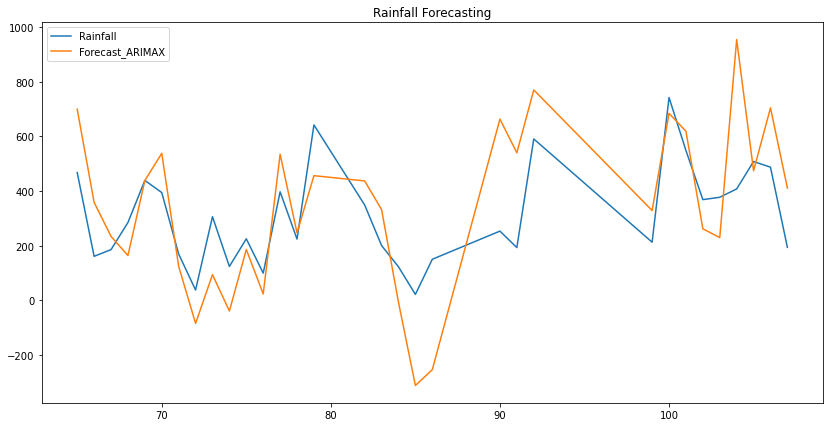

In [48]:
#Forecast using built model
valid[["Rainfall", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.title('Rainfall Forecasting')